# Stock Headline Scraper
By Ganel R. Nallamilli
***
This notebook is designed to scrape and parse stock-related headlines from benzinga using Selenium. The headlines can be used for further analysis, sentiment evaluation, or market trend observation.

##  Setup and Installation
Please read the GitHub readme to ensure you have installed the correct libraries and browser drivers. If you haven't installed a browser driver for Selenium, download it from the official site and ensure it's accessible in your system's PATH. For example, if you're using Firefox, you'll need GeckoDriver (which is what we use in this notebook).

***
## Contents
- **1. Introduction**
    - 1.1. Importing Libraries
    - 1.2. Helper Functions
- **2. Scraping Data**
    - 2.1. Executing the Scraper
        - 2.1.1. Setting Up the WebDriver
        - 2.1.2. Gathering News Headlines
- **3. Analyzing the Headlines**


***
# 1. Introduction
This notebook provides a step-by-step guide to scrape stock headlines from websites, particularly focusing on using the Selenium library to automate the process. By the end of this notebook, you will have a dataset of stock-related headlines that can be analyzed for various purposes.

Prerequisites:

- Basic knowledge of Python programming.
- Familiarity with web scraping concepts.
- Understanding of date and time handling in Python.
  
Assumptions:

-  user has a working internet connection.
-  necessary browser drivers (e.g., GeckoDriver for Firefox) are installed.

## 1.1. Importing Libraries 
In this section, we import the libraries required for web scraping and data handling.

- **Selenium:** Used for automating the browser interactions.
- **Pandas:** Useful for handling and processing the scraped data.
- **Datetime and Timedelta** For managing date and time data.
- **Time:** Used for adding delays when necessary.
- **WordCloud:** Generates word clouds from text data for visualization purposes.
- **Matplotlib:** A plotting library used to visualize data, such as displaying word clouds.

In [42]:
from selenium.webdriver.firefox.options import Options
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from datetime import datetime, timedelta
import pandas as pd
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## 1.2. Helper Functions
The following helper functions are used to parse dates from the headlines. These functions convert both specific and relative date formats into Python datetime objects for consistent data handling.

In [38]:
def parse_specific_date(date_str):
    try:
        date_format = '%b %d, %Y, %I:%M%p'
        return datetime.strptime(date_str, date_format)
    except ValueError:
        return None

def parse_relative_date(relative_str):
    now = datetime.now()
    
    if 'hour ago' in relative_str:
        hours_ago = int(relative_str.split(' ')[0])
        return now - timedelta(hours=hours_ago)

    if 'hours ago' in relative_str:
        hours_ago = int(relative_str.split(' ')[0])
        return now - timedelta(hours=hours_ago)
    
    if 'day ago' in relative_str:
        days_ago = int(relative_str.split(' ')[0])
        return now - timedelta(days=days_ago)

    if 'days ago' in relative_str:
        days_ago = int(relative_str.split(' ')[0])
        return now - timedelta(days=days_ago)

    return None

def parse_date(date_str):
    if 'hour ago' in date_str or 'day ago' in date_str or 'days ago' in date_str or 'hours ago' in date_str:
        return parse_relative_date(date_str)
    try:
        return parse_specific_date(date_str)
    except ValueError:
        pass
    
    return None


# 2. Scraping Data
Here, we set up the parameters for scraping, such as the stock ticker symbol and the date range.
- **Ticker:** The stock symbol for which headlines will be scraped. (Please sure your ticker is valid, you can manually visit 'https://www.benzinga.com/quote/(YOUR TICKER HERE)/news' to make sure you have a valid ticker.
- **End Date:** The cut-off date for scraping headlines.

In [34]:
ticker = 'goog'
end_date = datetime.strptime('20/07/2024', '%d/%m/%Y')

## 2.1. Executing the Scraper
***If you execute the cell blocks below and terminate early before executing the end code block make sure you run ```driver.quit()``` in a cell to shutdown the browser or it will continue running in the background.***

This section runs the web scraping process. The code will launch a browser in the background, navigate to the target website, and scrape headlines related to the specified stock ticker. If you would like to see the browser, simply remove the line ```options.add_argument("--headless")```.

### 2.1.1 Setting Up the WebDriver

In [ ]:
options = Options()
options.add_argument("--headless") #Remove this line if you want to see the browser.
driver = webdriver.Firefox(options = options) 
wait = WebDriverWait(driver, 10)

- **Options:** This configures the browser settings. The Options class is used to set preferences for the Selenium WebDriver.
- **Headless Mode:** options.add_argument("--headless") runs the browser in headless mode, meaning no GUI is displayed. This is useful for running scripts on servers or in environments where a display is unnecessary or unavailable. You can remove this line if you want to see the browser window while the script runs.
- **WebDriver: driver = webdriver.Firefox(options=options)** initializes a Firefox WebDriver instance using the options specified. The WebDriver is the automation engine that drives the browser.
- **WebDriverWait: wait = WebDriverWait(driver, 10)** creates a wait object that allows the script to pause execution until certain conditions are met (in this case, up to 10 seconds).

### 2.1.2 Gathering News Headlines
The code below automates a web scraping process to extract news headlines and their corresponding dates from Benzinga's website for a given stock ticker. It uses Selenium to navigate to the webpage and interact with elements on the page. The script repeatedly clicks a "load more" button to reveal additional news articles until a specified end date is reached. It then locates all relevant news items, filters out sponsored content, and collects the publication dates and headlines. These are stored in lists, which are later compiled into a Pandas DataFrame for further analysis. The process is wrapped in error handling to manage any potential issues during the scraping.

*Debugging: If you recieve any stale errors, try increase the time.sleep(x) times.*

In [35]:
driver.get(f'https://www.benzinga.com/quote/{ticker.upper()}/news')
loaded_dates = False
previous_date = None
while not loaded_dates:
    elem = driver.find_element(By.XPATH,'//*[@id="__next"]/div[2]/div[3]/div/div/div[1]/div[2]/div/div/div[3]/button')
    driver.execute_script("arguments[0].click();", elem)
    time.sleep(1)  
    
    div = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "content-title")))
    reversed_div = div[::-1]
    for i in range(len(reversed_div)):
        span = reversed_div[i].find_element(By.TAG_NAME, 'span')
        parent_div = reversed_div[i].find_element(By.XPATH, '..')
        if 'news-item-sponsored-tag' not in parent_div.get_attribute('outerHTML'):
            sub_div = parent_div.find_element(By.CSS_SELECTOR, '.text-gray-400.text-sm.author-date-text')
            date = parent_div.find_element(By.CSS_SELECTOR, '.text-gray-500.content-headline-datetime')
            data_obj = parse_date(date.get_attribute('innerHTML'))
            print(f'Current Date Loaded: {data_obj} | End Date: {end_date}')
            if data_obj < end_date or previous_date == data_obj:
                previous_date= data_obj
                loaded_dates = True
            break

print("Finished Loading Data")

dates = []
headline = []

# Locate all relevant div elements once
div_elements = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "content-title")))

for i, div in enumerate(div_elements):
    if i % 10 == 0:
        print(f'Finished Storing {i} Elements.')
        
    # Use a try-except block to handle any potential issues with finding elements
    try:
        span = div.find_element(By.TAG_NAME, 'span')
        parent_div = div.find_element(By.XPATH, '..')
        outer_html = parent_div.get_attribute('outerHTML')
        
        # Check if parent div has the sponsored tag
        if 'news-item-sponsored-tag' not in outer_html:
            # Check if the span does not contain '...'
            if '...' not in span.get_attribute('innerHTML'):
                # Extract date and headline text efficiently
                sub_div = parent_div.find_element(By.CSS_SELECTOR, '.text-gray-400.text-sm.author-date-text')
                date_element = parent_div.find_element(By.CSS_SELECTOR, '.text-gray-500.content-headline-datetime')
                
                # Store parsed date and headline
                dates.append(parse_date(date_element.get_attribute('innerHTML')))
                headline.append(span.get_attribute('innerHTML'))
    except Exception as e:
        print(f"Error processing element {i}: {e}")
driver.quit()

headline_df = pd.DataFrame({'date':dates, 'headlines':headline})

Current Date Loaded: 2024-08-03 02:18:00 | End Date: 2024-07-20 00:00:00
Current Date Loaded: 2024-08-02 07:17:00 | End Date: 2024-07-20 00:00:00
Current Date Loaded: 2024-07-30 15:43:00 | End Date: 2024-07-20 00:00:00
Current Date Loaded: 2024-07-29 06:25:00 | End Date: 2024-07-20 00:00:00
Current Date Loaded: 2024-07-25 08:11:00 | End Date: 2024-07-20 00:00:00
Current Date Loaded: 2024-07-24 12:12:00 | End Date: 2024-07-20 00:00:00
Current Date Loaded: 2024-07-24 04:19:00 | End Date: 2024-07-20 00:00:00
Current Date Loaded: 2024-07-23 08:27:00 | End Date: 2024-07-20 00:00:00
Current Date Loaded: 2024-07-22 07:51:00 | End Date: 2024-07-20 00:00:00
Current Date Loaded: 2024-07-17 16:38:00 | End Date: 2024-07-20 00:00:00
Finished Loading Data
Finished Storing 0 Elements.
Finished Storing 10 Elements.
Finished Storing 20 Elements.
Finished Storing 30 Elements.
Finished Storing 40 Elements.
Finished Storing 50 Elements.
Finished Storing 60 Elements.
Finished Storing 70 Elements.
Finished 

Now we have collected all news headlines up to around our end date, we can now save the data, and inspect the dataframe.

In [39]:
headline_df.to_parquet(f'{ticker}_headlines.parquet', engine='pyarrow')
headline_df

,date,headlines
0,2024-08-11 18:47:20.526043,Consumer Tech News (Aug 7-Aug 10): Walt Disney...
1,2024-08-10 00:47:20.612348,"Perplexity AI's Revenue, Usage Skyrocket As It..."
2,2024-08-10 00:47:20.713758,Power Of Oversold Bounce Overcomes Another Wea...
3,2024-08-10 00:47:20.761490,Alphabet Stock Bargain: Google Parent Has Lowe...
4,2024-08-10 00:47:20.810203,EXCLUSIVE: Which Magnificent 7 Stock Could Bes...
...,...,...
158,2024-07-18 12:28:00.000000,Trump Trade May Reverse As Probability Of Bide...
159,2024-07-18 11:33:00.000000,What's Going On With Nvidia And AMD Stocks On ...
160,2024-07-18 01:02:00.000000,Why Cathie Wood Is Betting On Small-Cap Stocks...
161,2024-07-17 17:59:00.000000,"Trump 'For TikTok,' Competition To Mark Zucker..."


# 3. Analyzing the Headlines
A good way to visually see what words are used is to use a word cloud.

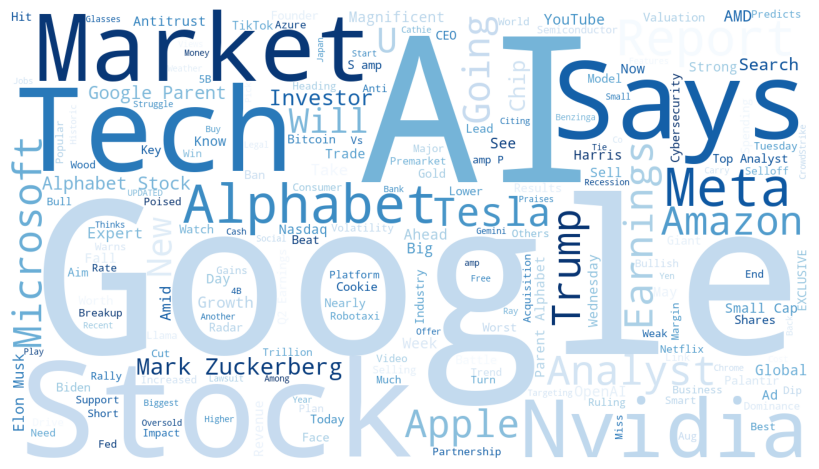

In [43]:
# Join the headlines into a single text string
text = ' '.join(headline_df['headlines'].tolist())
# Generate the WordCloud
wordcloud = WordCloud(width=1280, height=720, background_color='white', min_font_size=10, colormap='Blues').generate(text)
# Plot the WordCloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Here we see that 'google' and 'alphabet' both appear quite frequently in the text, and both relate to the company google. This could be useful to understand when it comes to finding the sentiment of the headlines as we know that headlines containing 'alphabet' will also affect google's overall sentiment. 